<div style="text-align: right"> Mark Hendricks </div>

<left>FINM 37400 - Fixed Income</left> 
<br>
<left>Winter 2024</left>

<h2><center> Homework #2- Fixed-Income Arbitrage in a Financial Crisis (A): US Treasuries in November 2008 </center></h2>

<center>Due: Wednesday, Jan 17 at 6PM</center>

<h3><span style="color:#00008B">Name - Nick Lewis</span></h3>
<h3><span style="color:#00008B">Email - nicklewis16@uchicago.edu</span></h3>

# Homework 2

## FINM 37400 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

# 1 HBS Case: Fixed-Income Arbitrage in a Financial Crisis (A): US Treasuries in November 2008

## Data
* Use the data file `treasury_ts_2015-08-15.xlsx`.
* Examine the treasure issues with `kytreasno` of `204046` and `204047`. These are the bond and note (respectively) which mature on 2015-08-15.
* Look at the data on 2008-11-04.

# IMPORTS AND HELPER FUNCTIONS

In [3]:
import pandas as pd
import numpy as np
import datetime
import warnings
import copy


from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from scipy import interpolate
from scipy.optimize import fsolve
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15

In [4]:
def bday(date):
    us_bus = CustomBusinessDay(calendar=USFederalHolidayCalendar())
    return bool(len(pd.bdate_range(date, date,freq=us_bus)))

def prev_bday(date,force_prev=False):
    if isinstance(date,str):
        date = datetime.datetime.strptime(date,'%Y-%m-%d')
        date2str = True
    else:
        date2str = False
        
    if force_prev:
        date += -datetime.timedelta(days=1)
    while not bday(date):
        date += -datetime.timedelta(days=1)
    
    if date2str:
        date = date.strftime('%Y-%m-%d')
        
    return date

def make_figure_number_issues_paying(CFmatrix):

    mask_issues_paying = (CFmatrix!=0).sum()

    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot(mask_issues_paying,marker='*',linestyle='None')

    #set ticks every quarter
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(2,5,8,11)))
    ax.xaxis.set_major_locator(mdates.YearLocator(month=2))

    #format ticks
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=60, horizontalalignment='right')

    ax.margins(x=0)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

    plt.ylabel('number of treasury issues with coupon or principal payment')
    plt.title('Number of Treasuries Paying')

    plt.show()

def get_bond(quote_date,maturity=None,coupon=None,selection='nearest'):
    
    metrics = process_treasury_quotes(quote_date)

    if coupon is not None:
        metrics = metrics[metrics['coupon rate']==coupon]
    
    if maturity is not None:
        mats = metrics['maturity interval']

        if type(maturity) is float:
            maturity = [maturity]

        idx = list()

        for m in maturity:

            if selection == 'nearest':
                idx.append(mats.sub(m).abs().idxmin())
            elif selection == 'ceil':
                idx.append(mats.sub(m).where(mats > 0, np.inf).argmin())
            elif selection == 'floor':
                idx.append(mats.sub(m).where(mats < 0, -np.inf).argmax())

        metrics = metrics.loc[idx,:]

    return metrics

def get_bond_raw(quote_date):
    
    filepath_rawdata = f'../data/treasury_quotes_{quote_date}.xlsx'
    rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
    rawdata.columns = rawdata.columns.str.upper()
    rawdata.sort_values('TMATDT',inplace=True)
    rawdata.set_index('KYTREASNO',inplace=True)

    t_check = rawdata['CALDT'].values[0]
    if rawdata['CALDT'].eq(t_check).all():
        t_current = t_check
    else:
        warnings.warn('Quotes are from multiple dates.')
        t_current = None
        
    return rawdata, t_current

def forward_discount(spot_discount,T1,T2):
    return spot_discount.loc[T2] / spot_discount.loc[T1]

def calc_npv(rate=0, cashflows=0, maturities=0, price=0):
        
    temp = cashflows.copy()
    val = sum([cfi/(1+rate)**(maturities[i]) for i, cfi in enumerate(temp)])
    val += - price

    return val

def check_dates(df):
    t_check = df['CALDT'].values[0]
    if df['CALDT'].eq(t_check).all():
        t_current = t_check
    else:
        warnings.warn('Quotes are from multiple dates.')
        t_current = None
    return t_current

def data_summary(rdata, t_current):
    res = rdata[['TDATDT','TMATDT','TCOUPRT','TDYLD','TDDURATN','TDPUBOUT']].copy()
    #TDYLD: PROMISED YIELD DAILY RATE, ALSO CALLED DAILY YIELD TO MATURITY.
    #IF A PRICE IS MISSING, THE tdyld IS SET TO -99
    res.columns = ['issue date','maturity date','coupon rate','yld', 'duration','outstanding']
    res['yld'] *= 365
    #DURATION: THE DAILY SERIES OF THE WEIGHTED AVERAGE NUMBER OF DAYS UNTIL THE CASH FLOWS OCCUR, WHERE THE PRESENT VALUES, DISCOUNTED BY YIELD TO MATURITY, 
    #OF EACH PAYMENT ARE USED AS THE WEIGHTS.
    res['duration'] /= 365
    #outstanding: DAILY SERIES OF THE AMOUNT (FACE VALUE) HELD BY THE PUBLIC IN MILLIONS OF DOLLARS
    res['outstanding'] *= 1e6
    res['maturity'] = get_maturity_delta(res['maturity date'], t_current)
    #TDACCINT: DAILY SERIES OF TOTAL ACCRUED INTEREST
    res['price'] = (rdata['TDBID'] + rdata['TDASK'])/2 + rdata['TDACCINT']
    res['bid-ask'] = rdata['TDASK'] - rdata['TDBID']
    res['next cashflow'] = (calc_cashflow(rdata)!=0).idxmax(1)
    return res

def process_treasury_quotes(quote_date):
    '''
    Provide quote date. Date is read into file assuming in same directory as this file.
    Data is processed raw prices (midpoint) are calculated.
    Rawdata and basic metrics are returned, make sure to have a tuple accept the function returns.
    '''
    #TDYLD: PROMISED YIELD DAILY RATE, ALSO CALLED DAILY YIELD TO MATURITY.
    #IF A PRICE IS MISSING, THE tdyld IS SET TO -99
    #DURATION: THE DAILY SERIES OF THE WEIGHTED AVERAGE NUMBER OF DAYS UNTIL THE CASH FLOWS OCCUR, WHERE THE PRESENT VALUES, DISCOUNTED BY YIELD TO MATURITY, 
    #OF EACH PAYMENT ARE USED AS THE WEIGHTS.
    #outstanding: DAILY SERIES OF THE AMOUNT (FACE VALUE) HELD BY THE PUBLIC IN MILLIONS OF DOLLARS
    #TDACCINT: DAILY SERIES OF TOTAL ACCRUED INTEREST
    filepath_rawdata = f'treasury_quotes_{quote_date}.xlsx'
    rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
    rawdata.columns = rawdata.columns.str.upper()
    rawdata.sort_values('TMATDT',inplace=True)
    rawdata.set_index('KYTREASNO',inplace=True)

    t_check = rawdata['CALDT'].values[0]
    if rawdata['CALDT'].eq(t_check).all():
        t_current = t_check
    else:
        warnings.warn('Quotes are from multiple dates.')
        t_current = None

    rawprices = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
    rawprices.name = 'price'

    maturity_delta = get_maturity_delta(rawdata['TMATDT'],t_current)
    maturity_delta.name = 'maturity delta'

    metrics = rawdata.copy()[['TDATDT','TMATDT','TDPUBOUT','TCOUPRT','TDYLD','TDDURATN']]
    metrics.columns = ['issue date','maturity date','outstanding','coupon rate','yld','duration']
    metrics['yld'] *= 365
    metrics['duration'] /= 365
    metrics['outstanding'] *= 1e6
    metrics['maturity'] = get_maturity_delta(metrics['maturity date'], t_current)
    metrics['price'] = rawprices
    metrics['bid-ask'] = rawdata['TDASK'] - rawdata['TDBID']
    metrics['next cashflow'] = (calc_cashflow(rawdata)!=0).idxmax(1)
    return rawdata, metrics

def get_maturity_delta(t_maturity,t_current):
    '''
    The `get_maturity_delta` function calculates the difference in time between the `t_maturity` and `t_current` dates,
    and returns the result as a float representing the number of years.
    '''
    maturity_delta = (t_maturity - t_current) / pd.Timedelta('365.25 days')
    
    return maturity_delta

def parse_date(date):
    """Parses a string date into a datetime object. If input is not a string, returns it as is."""
    return datetime.datetime.strptime(date, '%Y-%m-%d') if isinstance(date, str) else date

def get_coupon_dates(quote_date, maturity_date):
    """Generates coupon dates between quote date and maturity date."""
    quote_date, maturity_date = map(parse_date, [quote_date, maturity_date])
    periods = np.ceil((maturity_date - quote_date).days / 180)
    temp =  pd.date_range(end=maturity_date, periods=periods, freq = pd.DateOffset(months=6))
    #return coupon dates after quotation date
    next_coupon_date = pd.DataFrame(temp[temp > quote_date])[0]

    return next_coupon_date

def calc_cashflow(rdata):
    """
    Create a cash flow table for bonds based on their coupon dates and rates.

    Parameters:
    rdata: DataFrame containing bond information with columns 'CALDT' (issue date),
           'TMATDT' (maturity date), and 'TCOUPRT' (annual coupon rate).

    Returns:
    cf_table: DataFrame representing the cash flow of each bond.
    """

    # Initialize a DataFrame to store cash flows, with rows as bonds and columns as unique maturity dates
    cf_table = pd.DataFrame(0, index=rdata.index, columns=pd.to_datetime(rdata['TMATDT'].unique()))

    # Iterate over each bond to calculate cash flows
    for bond in rdata.itertuples():
        # Calculate all future coupon dates
        coupon_dates = get_coupon_dates(bond.CALDT, bond.TMATDT)

        # Add coupon rate to those dates (TCOUPRT is annual coupon rate, so divide by two for semiannual)
        if coupon_dates is not None:
            cf_table.loc[bond.Index, coupon_dates] = bond.TCOUPRT / 2

        # Add face value at maturity
        cf_table.loc[bond.Index, bond.TMATDT] += 100

    # Fill any NaN values with 0 and sort the columns by date
    cf_table.fillna(0, inplace=True)
    cf_table.sort_index(axis=1, inplace=True)

    # Remove columns where all values are zero
    cf_table = cf_table.loc[:, (cf_table != 0).any()]

    return cf_table

def filter_treasuries(data, 
                      t_date=None, 
                      max_maturity_years=None, 
                      min_maturity_years=None, 
                      drop_duplicate_maturities=False, 
                      include_tips=False, 
                      exclude_zero_yield=True):
    """
    Filters a DataFrame of treasury data based on various criteria.

    Parameters:
    data: DataFrame containing treasury data.
    t_date: Date to filter the data on. Defaults to the latest 'CALDT' in the data.
    max_maturity_years: Maximum maturity in years to include. None means no maximum.
    min_maturity_years: Minimum maturity in years to include. None means no minimum.
    drop_duplicate_maturities: Boolean, if True, drops duplicate maturity dates.
    include_tips: Boolean, if False, excludes TIPS (Treasury Inflation Protected Securities).
    exclude_zero_yield: Boolean, if True, excludes entries with zero yield.

    Returns:
    Filtered DataFrame based on the specified criteria.
    """

    filtered_data = data.copy()

    # Set target date to the latest 'CALDT' if not provided
    if t_date is None:
        t_date = filtered_data['CALDT'].values[-1]

    # Filter data for the target date
    filtered_data = filtered_data[filtered_data['CALDT'] == t_date]

    # Drop duplicate maturities if required
    if drop_duplicate_maturities:
        filtered_data = filtered_data.drop_duplicates(subset=['TMATDT'])

    # Filter by maximum maturity date
    if max_maturity_years is not None:
        max_maturity_date = t_date + pd.DateOffset(years=max_maturity_years)
        filtered_data = filtered_data[filtered_data['TMATDT'] < max_maturity_date]

    # Filter by minimum maturity date
    if min_maturity_years is not None:
        min_maturity_date = t_date + pd.DateOffset(years=min_maturity_years)
        filtered_data = filtered_data[filtered_data['TMATDT'] > min_maturity_date]

    # Include or exclude TIPS based on the include_tips flag
    if not include_tips:
        filtered_data = filtered_data[~filtered_data['ITYPE'].isin([11, 12])]

    # Exclude entries with zero yield if required
    if exclude_zero_yield:
        filtered_data = filtered_data[filtered_data['TDYLD'] > 0]

    return filtered_data

def filter_treasury_cashflows(CF, filter_maturity_dates=False, filter_benchmark_dates=False, filter_CF_strict=True):

    mask_benchmark_dts = []
    
    # Filter by using only benchmark treasury dates
    for col in CF.columns:
        if filter_benchmark_dates:
            if col.month in [2,5,8,11] and col.day == 15:
                mask_benchmark_dts.append(col)
        else:
            mask_benchmark_dts.append(col)
    
    if filter_maturity_dates:
        mask_maturity_dts = CF.columns[(CF>=100).any()]
    else:
        mask_maturity_dts = CF.columns
    
    mask = [i for i in mask_benchmark_dts if i in mask_maturity_dts]

    CF_filtered = CF[mask]
          
    if filter_CF_strict:
        # drop issues that had CF on excluded dates
        mask_bnds = CF_filtered.sum(axis=1) == CF.sum(axis=1)
        CF_filtered = CF_filtered[mask_bnds]

    else:
        # drop issues that have no CF on included dates
        mask_bnds = CF_filtered.sum(axis=1) > 0
        CF_filtered = CF_filtered[mask_bnds]
        
        
    # update to drop dates with no CF
    CF_filtered = CF_filtered.loc[:,(CF_filtered>0).any()]
    
    return CF_filtered

def present_value(rate, cashflows, maturities, freq=1):
    """
    Calculate the present value of a series of cashflows.

    Parameters:
    rate: Discount rate.
    cashflows: Sequence of cashflows.
    maturities: Sequence of time to each cashflow in years.
    frequency: Compounding frequency per year.

    Returns:
    The present value of the cashflows.
    """
    return sum(cashflow / (1 + rate / freq) ** (time * freq) 
               for cashflow, time in zip(cashflows, maturities))
    
def compound_rate(intrate,compound_input,compound_output):
    '''
    The `compound_rate` function calculates the compound interest rate based on the given inputs.
    '''
    if compound_input is None:
        outrate = compound_output * (np.exp(intrate/compound_output) - 1)
    elif compound_output is None:
        outrate = compound_input * np.log(1 + intrate/compound_input)
    else:
        outrate = ((1 + intrate/compound_input) ** (compound_input/compound_output) - 1) * compound_output

    return outrate

def discount_to_intrate(discount, maturity, n_compound=None):
    """
    Convert discount factor to interest rate.
    
    Parameters:
    discount: Discount factor.
    maturity: Maturity period of the bond.
    n_compound: Number of compounding periods per year. If None, continuous compounding is assumed.
    
    Returns:
    Interest rate corresponding to the discount factor.
    """
    if n_compound is None:  # Continuous compounding
        intrate = -np.log(discount) / maturity
    else:  # Periodic compounding
        intrate = n_compound * ((1/discount)**(1/(n_compound * maturity)) - 1)
    
    return intrate

def intrate_to_discount(intrate, maturity, n_compound=None):
    """
    Convert interest rate to discount factor.
    
    Parameters:
    intrate: Interest rate.
    maturity: Maturity period of the bond.
    n_compound: Number of compounding periods per year. If None, continuous compounding is assumed.
    
    Returns:
    Discount factor corresponding to the interest rate.
    """
    if n_compound is None:  # Continuous compounding
        discount = np.exp(-intrate * maturity)
    else:  # Periodic compounding
        discount = 1 / (1 + (intrate / n_compound))**(n_compound * maturity)

    return discount

def bootstrap(params, maturity):
    """
    Estimate the rate for a given maturity using bootstrap method.
    
    Parameters:
    params: Tuple containing estimated maturities and beta coefficients.
    maturity: Maturity for which the rate is to be estimated.
    
    Returns:
    Estimated rate for the given maturity.
    """
    estimated_maturities, betas = params
    estimated_rates = discount_to_intrate(betas, estimated_maturities)
    rate_interpolator = interpolate.interp1d(estimated_maturities, estimated_rates, 
                                             bounds_error=False, fill_value='extrapolate')
    return rate_interpolator(maturity)

def semi_bootstrap(params,maturity, n_compound):
    estimated_maturities = params[0]
    betas = params[1]
    estimated_rates = discount_to_intrate(betas,estimated_maturities, n_compound=n_compound)
    
    f = interpolate.interp1d(estimated_maturities, estimated_rates, bounds_error=False, fill_value='extrapolate')
    
    rate = f(maturity)

    return rate

def estimate_curve_ols(CF, prices, interpolate=False):
    """
    Estimate the discount curve using Ordinary Least Squares (OLS).
    
    Parameters:
    CF: Cash flow matrix.
    prices: Prices of the bonds.
    interpolate: Boolean, if True, interpolates the discount factors.
    
    Returns:
    Estimated discount factors.
    """
    if isinstance(prices, (pd.DataFrame, pd.Series)):
        prices = prices[CF.index].values

    model = LinearRegression(fit_intercept=False)
    model.fit(CF.values, prices)

    if interpolate:
        mat_grid = get_maturity_delta(CF.columns, CF.columns.min())
        valid_coef = np.logical_and(model.coef_ < 1.25, model.coef_ > 0)
        y_interpolator = interpolate.interp1d(mat_grid[valid_coef], model.coef_[valid_coef], 
                                              bounds_error=False, fill_value='extrapolate')
        discounts = y_interpolator(mat_grid)
    else:
        discounts = model.coef_

    return discounts

def estimate_rate_curve(model,CF,t_current,prices,x0=None):

    if model is bootstrap:
        params = estimate_curve_ols(CF,prices,interpolate=False)
        
        CF_intervals = get_maturity_delta(CF.columns.to_series(),t_current=t_current).values
    
        params_optimized = [CF_intervals,params]

    else:
        if x0 is None:
            if model is nelson_siegel:
                x0 = np.ones((1,4))/10
            elif model is nelson_siegel_extended:
                x0 = np.ones((1,6))
            else:
                x0 = 1        

        mod = minimize(pricing_errors, x0, args=(CF, t_current, model, prices))
        params_optimized = mod.x

    return params_optimized

def nelson_siegel(params,maturity):
    rate = params[0] + (params[1] + params[2]) * (1 - np.exp(-maturity/params[3]))/(maturity/params[3]) - params[2] * np.exp(-maturity/params[3])
    
    return rate

def nelson_siegel_extended(params,maturity):
    rate = params[0] + (params[1] + params[2]) * (1 - np.exp(-maturity/params[3]))/(maturity/params[3]) - params[2] * np.exp(-maturity/params[3]) + params[4] *((1-np.exp(-maturity/params[5]))/(maturity/params[5]) - np.exp(-maturity/params[5]))
    
    return rate

def extract_spot_curves(quote_date, filepath=None, model=nelson_siegel, delta_maturity = .25, T=30,calc_forward=False, delta_forward_multiple = 1, filter_maturity_dates=False, filter_tips=True):

    if filepath is None:
        filepath = f'../data/treasury_quotes_{quote_date}.xlsx'
        
    rawdata = pd.read_excel(filepath,sheet_name='quotes')
    
    rawdata.columns = rawdata.columns.str.upper()
    rawdata.sort_values('TMATDT',inplace=True)
    rawdata.set_index('KYTREASNO',inplace=True)

    t_check = rawdata['CALDT'].values[0]
    if rawdata['CALDT'].eq(t_check).all():
        t_current = t_check
    else:
        warnings.warn('Quotes are from multiple dates.')
        t_current = None

    rawprices = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
    rawprices.name = 'price'

    ###
    data = filter_treasuries(rawdata, t_date=t_current, filter_tips=filter_tips)

    CF = filter_treasury_cashflows(calc_cashflow(data),filter_maturity_dates=filter_maturity_dates)
    prices = rawprices[CF.index]

    ###
    params = estimate_rate_curve(model,CF,t_current,prices)
    
    if model == nelson_siegel_extended:
        params0 = estimate_rate_curve(nelson_siegel,CF,t_current,prices)
        x0 = np.concatenate((params0,(1,1)))
        params = estimate_rate_curve(model,CF,t_current,prices,x0=x0)
        
    else:
        params = estimate_rate_curve(model,CF,t_current,prices)

    ###
    maturity_grid = np.arange(0,T+delta_maturity,delta_maturity)
    maturity_grid[0] = .01
    
    curves = pd.DataFrame(index = pd.Index(maturity_grid,name='maturity'))
    # adjust earliest maturity from 0 to epsion
    curves.columns.name = quote_date
    
    curves['spot rate']= model(params,maturity_grid)

    curves['spot discount'] = intrate_to_discount(curves['spot rate'].values,curves.index.values)
    
    
    
    if calc_forward:
        delta_forward = delta_forward_multiple * delta_maturity
        
        curves['forward discount'] = curves['spot discount'] / curves['spot discount'].shift(delta_forward_multiple)

        # first value of forward is spot rate
        maturity_init = curves.index[0:delta_forward_multiple]
        curves.loc[maturity_init,'forward discount'] = curves.loc[maturity_init,'spot discount']
        
        curves.insert(2,'forward rate', -np.log(curves['forward discount'])/delta_forward)
        
    return curves

def pricing_errors(params,CF,t_current,fun_model,observed_prices):

    price_modeled = price_with_rate_model(params,CF,t_current,fun_model)

    if isinstance(observed_prices,pd.DataFrame) or isinstance(observed_prices,pd.Series):
        observed_prices = observed_prices.values
        
    error = sum((observed_prices - price_modeled)**2)
    
    return error

def price_with_rate_model(params,CF,t_current,fun_model, convert_to_discount=True, price_coupons=False):

    maturity = get_maturity_delta(CF.columns, t_current)
    
    if convert_to_discount:
        disc = np.zeros(maturity.shape)
        for i, mat in enumerate(maturity):
            disc[i] = intrate_to_discount(fun_model(params,mat),mat)
    else:
        disc = fun_model(params,mat)
        
        
    if price_coupons:
        price = CF * disc
    else:
        price = CF @ disc
    
    return price

def get_spread_bps(database):
    ylds = database.pivot_table(index='CALDT',columns='KYTREASNO',values='TDYLD')
    ylds *= 365 * 100 * 100
    
    spread = -ylds.sub(ylds.iloc[:,0],axis=0)
    
    return spread

def get_key_info(info):
    keys = ['kytreasno','tdatdt','tmatdt','tcouprt','itype']
    key_info = info.loc[keys]
    key_info.index = ['kytreasno','issue date','maturity date','coupon rate','type']
    key_info.loc['type',key_info.loc['type']==1] = 'bond'
    key_info.loc['type',key_info.loc['type']==2] = 'note'
    key_info.loc['type',key_info.loc['type']==3] = 'bill'
    key_info.loc['type',key_info.loc['type']==11] = 'TIPS bond'
    key_info.loc['type',key_info.loc['type']==12] = 'TIPS note'
    key_info.columns = key_info.loc['issue date']
    return key_info

def get_snapshot(database,date):    
    
    datasnap = database[database['CALDT']==date].T
    
    metrics = datasnap.loc[['KYTREASNO','CALDT','TDBID','TDASK','TDACCINT']]
    metrics.loc['clean price'] = (metrics.loc['TDBID'] + metrics.loc['TDASK'])/2
    metrics.loc['dirty price'] = metrics.loc['clean price'] + metrics.loc['TDACCINT']
    metrics.loc['duration'] = datasnap.loc['TDDURATN'] / 365.25
    ytm = (datasnap.loc['TDYLD'] * 365.25)
    metrics.loc['modified duration'] = metrics.loc['duration'] / (1+ytm/2)
    metrics.loc['ytm'] = ytm
    metrics.columns = metrics.loc['CALDT']
    metrics.drop('CALDT',inplace=True)
    metrics.index = metrics.index.str.lower()
    metrics.rename({'tdbid':'bid','tdask':'ask','tdaccint':'accrued interest'},inplace=True)
    
    return metrics

def get_table(info,database,date):

    keyinfo = get_key_info(info)
    metrics = get_snapshot(database,date)

    table = pd.merge(keyinfo.T,metrics.T,on='kytreasno',how='inner').T
    table.columns = table.loc['kytreasno']
    table.drop('kytreasno',inplace=True)
    
    return table

def pnl_spread_trade(spread_convergence, modified_duration, price, contracts):    
    table = pd.DataFrame(dtype='float64',index=modified_duration.index)
    table['ytm change'] = spread_convergence/2 * np.array([-1,1])
    table['modified duration'] = modified_duration    
    table['price'] = price
    table['contracts'] = contracts
    table['pnl'] = - table['modified duration'] * table['price'] * table['ytm change'] * table['contracts']
    table.loc['total','pnl'] = table['pnl'].sum()
        
    fmt_dict = {'ytm change':'{:.4%}','modified duration':'{:,.2f}','dollar modified duration':'{:,.2f}','contracts':'{:,.2f}','price':'${:,.2f}','pnl':'${:,.2f}'}
    
    return table, fmt_dict

def trade_balance_sheet(prices, durations, haircuts, key_long, key_short, long_equity=None, long_assets=None):

    hedge_ratio = -durations[key_long]/durations[key_short]

    balsheet = pd.DataFrame(dtype='float64',index=[key_long,key_short],columns=['equity','assets'])

    if long_equity is not None:
        balsheet['assets'] = long_equity / haircuts.values
    elif long_assets is not None:
        balsheet.loc[key_long,'assets'] = long_assets
    else:
        error('Must input long equity or long assets.')
        
    balsheet.loc[key_short,'assets'] = balsheet.loc[key_long,'assets'] * hedge_ratio
    balsheet['equity'] = balsheet['assets'] * haircuts.values

    balsheet['contracts'] = balsheet['assets'] / prices
    fmt = {'equity':'${:,.2f}','assets':'${:,.2f}','contracts':'{:,.2f}'}
    
    return balsheet, fmt

def trade_evolution(date0, date_maturity, n_weeks, balsheet, price_ts, duration_ts, financing, cpn_rates, key_long, key_short):

    dt0 = datetime.datetime.strptime(date0,'%Y-%m-%d') 
    
    cpn_dates = get_coupon_dates(date0,date_maturity)
    
    pnl = pd.DataFrame(dtype='float64',index=[dt0],columns=['price change', 'coupons', 'total pnl', 'equity'])
    pnl.loc[dt0] = [0, 0, 0, balsheet['equity'].abs().sum()]

    for i in range(1,n_weeks):
        dt = dt0 + datetime.timedelta(weeks=i)
        dt = prev_bday(dt)

        cpn_payments = (dt > cpn_dates).sum()
        pnl.loc[dt,'price change'] = (price_ts.loc[[dt0,dt]] * balsheet['contracts']).diff().sum(axis=1).loc[dt]
        pnl.loc[dt,'coupons'] = (cpn_rates * balsheet['contracts'] * cpn_payments / 2).sum()
        pnl.loc[dt,'total pnl'] = pnl.loc[dt,['price change','coupons']].sum()

        temp, _ = trade_balance_sheet(price_ts.loc[dt], duration_ts.loc[dt], financing['haircut'], key_long, key_short, long_assets=balsheet.loc[key_long,'contracts']*price_ts.loc[dt,key_long])
        pnl.loc[dt,'equity'] = temp['equity'].abs().sum()

    pnl['margin call'] = pnl['equity'].diff() - pnl['total pnl'].diff()
    pnl.loc[dt0,'margin call'] = 0
    pnl['capital paid in'] = pnl['equity'] + pnl['margin call'].cumsum()

    pnl['return (init equity)'] = pnl['total pnl'] / pnl.loc[dt0,'capital paid in']
    pnl['return (avg equity)'] = pnl['total pnl'] / pnl['capital paid in'].expanding().mean()

    fmt_dict = {'price change':'${:,.2f}','coupons':'${:,.2f}','total pnl':'${:,.2f}','equity':'${:,.2f}','margin call':'${:,.2f}','capital paid in':'${:,.2f}', 'return (init equity)':'{:.2%}', 'return (avg equity)':'{:.2%}'}

    return pnl, fmt_dict

# READ IN DATA

In [6]:
date = '2015-08-15'
filepath_tsdata = f'../data/treasury_ts_{date}.xlsx'
info = pd.read_excel(filepath_tsdata,sheet_name='info',index_col=0)
tsdata = pd.read_excel(filepath_tsdata,sheet_name='database')
tsdata.columns = tsdata.columns.str.upper()


## 1.1 The situation

Make a chart comparing the issues in the following features, (as of Nov 4, 2008.)
* coupon rate
* bid
* ask
* accrued interest
* dirty price
* duration (quoted in years, not days, assuming 365.25 days per year.)
* modified duration
* YTM

In [7]:
date = '2008-11-04'
tab = get_table(info, tsdata, date)
tab

kytreasno,204046,204047
issue date,1985-08-15 00:00:00,2005-08-15 00:00:00
maturity date,2015-08-15 00:00:00,2015-08-15 00:00:00
coupon rate,10.625,4.25
type,bond,note
bid,141.859375,105.953125
ask,141.890625,105.984375
accrued interest,2.338655,0.935462
clean price,141.875,105.96875
dirty price,144.213655,106.904212
duration,5.230138,5.935706


## 1.2 Hedge Ratio

Suppose you are building a trade to go long $n_i$ bonds (`204046`) and short $n_j$ notes (`204047`).

We can find an equation for $n_j$ in terms of $n_i$ such that the total holdings will have duration equal to zero. (Having zero duration also means have zero dollar duration, if helpful.)

Notation:
* $n_i$: number of bonds purchased (or sold)
* $D_i$: duration of bond $i$
* $D_{\$,i}$: dollar duration of bond $i$, equal to $p_iD_i$

If we want the total duration of our holdings to be zero, then we need to size the trade such that $n_i$ and $n_j$ satisfy,

$$0 = n_iD_{\$,i} + n_jD_{\$,j}$$

$$n_j = -n_i\frac{D_{\$,i}}{D_{\$,j}}$$

Suppose you will use \\$1mm of capital, leveraged 50x to buy \\$50mm of the bonds (`204046`).

Use the ratio above to short a number of notes (`204047`) to keep zero duration.

Report the number of bonds and notes of your position, along with the total dollars in the short position.

In [8]:
financing = pd.DataFrame(dtype='float64',index=['long','short'])
financing['haircut'] = [.02,.02]
financing['repo'] = [.0015,.0010]
keyLong = tab.loc['ytm'].astype('float64').idxmax()
keyShort = tab.loc['ytm'].astype('float64').idxmin()

LONGEQUITY = 1e6

balsheet, fmt = trade_balance_sheet(prices=tab.loc['dirty price'], durations=tab.loc['duration'], 
                                    haircuts=financing['haircut'], long_equity=LONGEQUITY, 
                                    key_long=keyLong, key_short=keyShort)
display(balsheet.style.format(fmt,na_rep=''))

,equity,assets,contracts
204046,"$1,000,000.00","$50,000,000.00","346,707.81"
204047,"$-881,131.58","$-44,056,578.93","-412,112.66"


## 1.3 Profit Opportunity

Using the concept of **modified duration**, how much profit or loss (PnL) would you expect to make for every basis point of convergence in the spread? Specifically, assume the convergence is symmetric: the bond's (`204046`) ytm goes down 0.5bp and the note (`204047`) ytm goes up 0.5bp.

Describe the PnL you would expect to achieve on your position should this happen. Specify the PnL of the long position, the short position, and the net total.

Suppose the spread in YTM between the two securities disappears, due to a symmetric move of roughly ~17bps in each security's YTM. What is the PnL? (This is just a linearly scaling of your prior answer for a 1bp convergence.) 


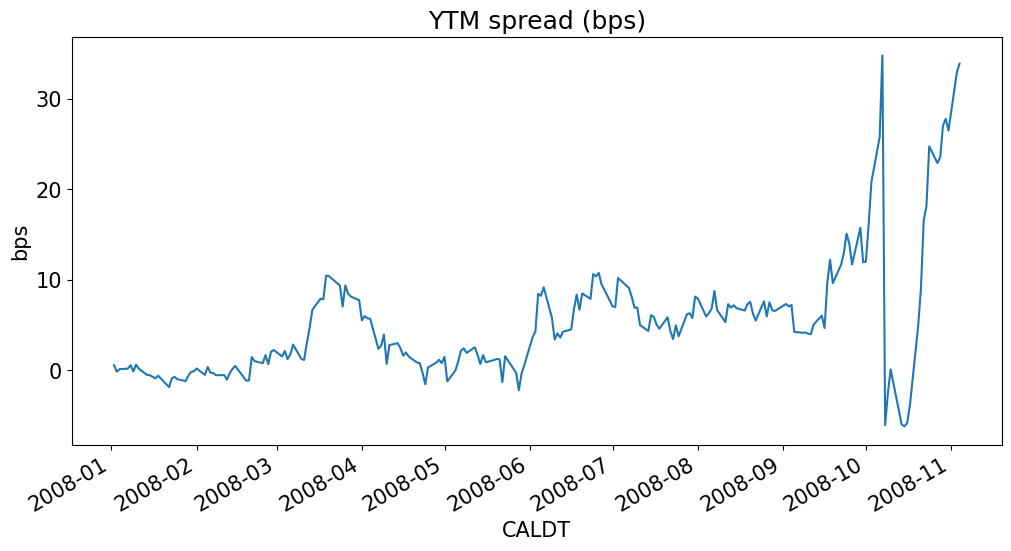

Spread converges:


,ytm change,modified duration,price,contracts,pnl
kytreasno,,,,,
204046,-0.1695%,5.14,$144.21,"346,707.81","$435,509.58"
204047,0.1695%,5.84,$106.90,"-412,112.66","$436,236.08"
total,,,,,"$871,745.67"


1 bp move:


,ytm change,modified duration,price,contracts,pnl
kytreasno,,,,,
204046,-0.0050%,5.14,$144.21,"346,707.81","$12,845.71"
204047,0.0050%,5.84,$106.90,"-412,112.66","$12,867.14"
total,,,,,"$25,712.85"


Opportunity summary:


,pnl,return
converges,"$871,745.67",46.34%
1bp,"$25,712.85",1.37%


In [10]:
spread = get_spread_bps(tsdata)
spread = spread[keyShort]
spread.rename('ytm spread (bps)',inplace=True)
spread.loc['2008':'2008-11-04'].plot(ylabel='bps',title='YTM spread (bps)')
plt.show()


spread_convergence = tab.loc['ytm'].diff().dropna().abs().values[0]
pnl_spread_converges, fmt_dict = pnl_spread_trade(spread_convergence,tab.loc['modified duration'], 
                                                tab.loc['dirty price'], balsheet['contracts'])
print('Spread converges:')
display(pnl_spread_converges.style.format(fmt_dict,na_rep=''))

spread_convergence = .0001
pnl_spread_1bp, fmt_dict = pnl_spread_trade(spread_convergence,tab.loc['modified duration'], tab.loc['dirty price'], balsheet['contracts'])
print('1 bp move:')
display(pnl_spread_1bp.style.format(fmt_dict,na_rep=''))

opportunity = pd.DataFrame([pnl_spread_converges.loc['total','pnl'], pnl_spread_1bp.loc['total','pnl']], columns=['pnl'],index=['converges','1bp'])
opportunity['return'] = opportunity['pnl'] / balsheet['equity'].abs().sum()
print('Opportunity summary:')
display(opportunity.style.format({'return':'{:.2%}','pnl':'${:,.2f}'}))


## 1.4 Result in 2008

Calculate the profit (or loss) on the position on the following two dates:
* 2008-11-25
* 2008-12-16

To calculate the pnl on each date, simply use the prices of the securities on those dates along with your position sizes, ($n_i, n_j$). No coupon is being paid in November or December, so all you need is the "dirty" price on these two dates.

Does the pnl make sense (approximately) given your results in 1.3 with regard to the sensitivity of pnl to moves in the YTM spread?

In [11]:
ask = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK')
bid = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDBID')
accint = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDACCINT')
dirty = (ask + bid)/2 + accint
dirty = dirty[[keyLong,keyShort]]
duration = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDDURATN')[[keyLong,keyShort]] / 365.25

,price change,coupons,total pnl,ytm spread (bps)
2008-11-04 00:00:00,$0.00,$0.00,$0.00,33.88
2008-11-10 00:00:00,"$-115,883.84",$0.00,"$-115,883.84",38.54
2008-11-18 00:00:00,"$-181,887.02",$0.00,"$-181,887.02",41.15
2008-11-25 00:00:00,"$-499,072.82",$0.00,"$-499,072.82",52.96
2008-12-02 00:00:00,"$-748,066.35",$0.00,"$-748,066.35",61.46
2008-12-09 00:00:00,"$-903,774.22",$0.00,"$-903,774.22",67.29
2008-12-16 00:00:00,"$-1,049,332.75",$0.00,"$-1,049,332.75",71.61
2008-12-23 00:00:00,"$-805,707.20",$0.00,"$-805,707.20",63.50
2008-12-30 00:00:00,"$-756,986.09",$0.00,"$-756,986.09",61.81


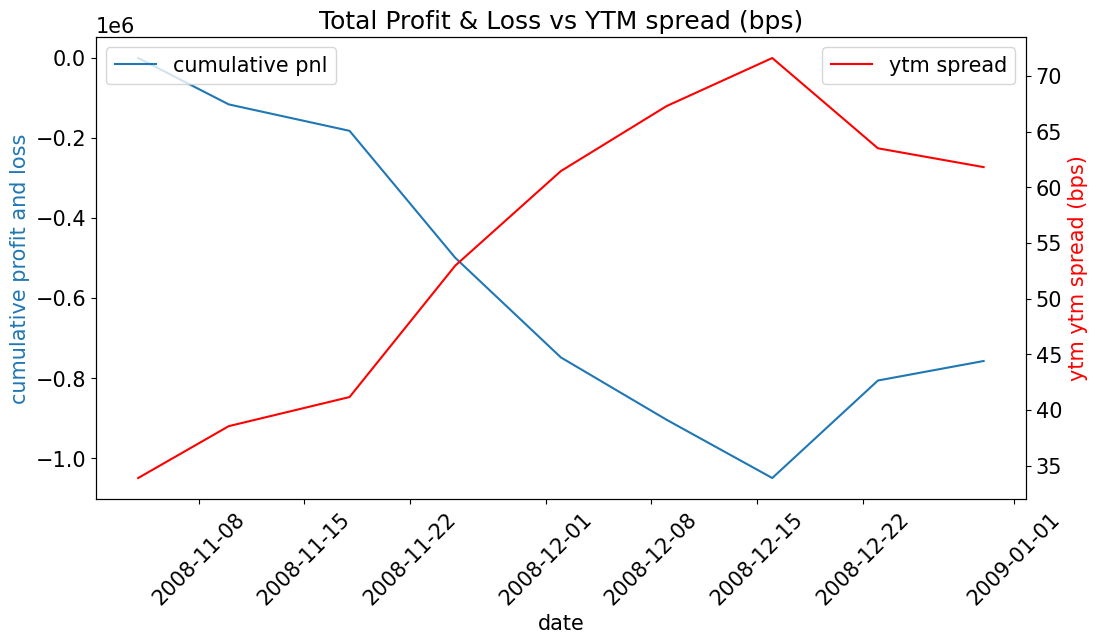

In [12]:
n_weeks = 9
trade, fmt_dict = trade_evolution(date, tab.loc['maturity date',keyShort], n_weeks, balsheet, 
                                dirty, duration, financing, tab.loc['coupon rate'], keyLong, keyShort)

summary = trade[['price change','coupons','total pnl']].join(spread,how='left')
fmt = fmt_dict
fmt['ytm spread (bps)'] = '{:.2f}'
display(summary.style.format(fmt,na_rep=''))
fig, ax = plt.subplots()

ax.plot(summary[['total pnl']])
ax.set_xlabel('date');
ax.set_ylabel('cumulative profit and loss',color=ax.get_lines()[-1].get_color())
ax.tick_params(axis='x', rotation=45)
ax.legend(['cumulative pnl'],loc=2)

ax2 = ax.twinx()
ax2.plot(summary[['ytm spread (bps)']], color='r')
ax2.set_ylabel('ytm ytm spread (bps)',color=ax2.get_lines()[-1].get_color())
ax2.legend(['ytm spread'],loc=1)

ax.set_title('Total Profit & Loss vs YTM spread (bps)')
plt.show()


## 1.5 Examining the Trade through June 2009

Calculate the pnl of the trade for the following dates:
* 2009-01-27
* 2009-03-24
* 2009-06-16

Did the trade do well or poorly in the first six months of 2009?

Calculate the YTM spreads on these dates. Does the YTM spread correspond to pnl roughly as we would expect based on the calculation in 1.3?

***

# 2 Hedging Duration

Import `treasury_ts_issue_duration_(207392, 207391, 207404).xlsx`.

I suggest using code such as

* `tsdata = pd.read_excel(filepath_tsdata,sheet_name='ts')`

* `tsdata.columns = tsdata.columns.str.upper()`

* `px = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK').dropna()`
* `duration = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDDURATN').dropna()`

## 2.1 

Suppose you have a portfolio of 10,000 USD long in security `207391` on the last day of the sample.

If you want to manage interest rate exposure using duration, how large of a short position should you hold in `207392`?

(Duration is the column `TDDURATN` in the raw data.)

## 2.2

Step through the time-series, doing the following:

* Starting at the end of the first day, set the hedged position according to the relative given durations.
* Use the second day's price data to evaluate the net profit or loss of the hedged position.
* Reset the the hedged position using the end-of-second-day durations. Again fix the long position of security `207391` to be 10,000.
* Repeat throughout the timeseries.

Report 
* the total profit (or loss.)
* the mean, standard deviation, min, and max of the daily profit or loss.

***

# 3 Calculating Duration Via Individual Cashflows

## *Optional*

***No need to submit this problem, but if we discuss it, then you are expected to know it.***

Use the data file `../data/treasury_quotes_2023-07-26.xlsx`.

This data reports duration as `TDDURATN`. It quotes the duration in days, so I recommend dividing by 365 to get the duration in its usual format.

## 3.1 
Set up the cashflow matrix. 


## 3.2
Build a discount curve assuming that the spot rate is 2\% per year, continuously compounded.

Plot the discount curve and the associated spot curve out to 30 years maturity.

*Note, you do not need to properly extract a spot curve and associated discount factors; rather, you are simply assuming a flat term structure of spot rates at 2\% and using that to figure out discount rates.*

## 3.3
For each treasury issue, calculate the duration as the weighted average of the (discounted!) cashflow maturity.

Report the summary statistics of the durations. (Use `.describe()` from pandas.)


## 3.4
How close are your duration estimates to the imputed durations given in the data source, (column `TDDURATN`)?

Report the summary statistics of the imputed durations minus your calculated durations from above.

Why might they be different?

## 3.5
Continue using your assumed discount rates of 2\% to calculate the convexity of each issue.

Report the summary statistics of these convexity calculations.

## 3.6

Re-do the duration and convexity calculations using an extracted discount curve instead of a discount curve based on a constant (arbitrary) spot rate. 

***

# 4 Other Interest-Rate Risks

## *Optional*

***No need to submit this problem, but if we discuss it, then you are expected to know it.***

## 4.1 Other Yield Curve Movements

Use the yield curve time-series data in `'../data/yields.xlsx` to calculate the time-series of the **level**, **slope**, and curvature** factors.

Calculate the yield-curve factors. For each point in time, calculate the following three factors:

$\begin{align}
x^{\text{level}}_t =& \frac{1}{N_{\text{yields}}}\sum_{i=1}^{N_{\text{yields}}} y^{(i)}_t\\
x^{\text{slope}}_t =& y^{(30)}_t - y^{(1)}_t\\
x^{\text{curvature}}_t =& -y^{(1)}_t + 2 y^{(10)}_t - y^{(30)}_t
\end{align}$

Report the mean and volatility of each factor.

Report the correlation matrix of the factors.

## 4.2 Factor Duration

Calculate the factor duration of the treasuries from `treasury_ts_issue_duration_(207392, 207391, 207457).xlsx`.

Run a multivariate regression of the bond prices on all three factors constructed above from the yield factors: level, slope, and curvature. 

Estimate the regression in the form of day-over-day differences for both bond prices and factors. That is, we are using regression to approximate the factor duration equation,

$\begin{align}
\frac{dP}{P} = \beta_1 dz_1 + \beta_2 dz_2 + \beta_3 dz_3 + \epsilon
\end{align}$

Report the betas for each of these factors, for each of the bond prices.

***